In [124]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

import sqlite3
from sklearn.externals import joblib
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

## Load Data

In [119]:
scores = pd.read_csv('../data/user_assessment_scores.csv')
views = pd.read_csv('../data/user_course_views.csv')
tags = pd.read_csv('../data/course_tags.csv')
interests = pd.read_csv('../data/user_interests.csv')

In [4]:
scores.head()

,user_handle,assessment_tag,user_assessment_date,user_assessment_score
0,7487,angular-js,2017-08-11 19:03:38,134
1,7487,css,2017-08-11 20:09:56,38
2,7487,html5,2017-07-31 18:59:37,84
3,7487,java,2017-07-31 18:49:27,149
4,7487,javascript,2017-07-31 19:05:03,92


In [5]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6571 entries, 0 to 6570
Data columns (total 4 columns):
user_handle              6571 non-null int64
assessment_tag           6571 non-null object
user_assessment_date     6571 non-null object
user_assessment_score    6571 non-null int64
dtypes: int64(2), object(2)
memory usage: 205.4+ KB


In [6]:
views.head()

,user_handle,view_date,course_id,author_handle,level,view_time_seconds
0,1,2017-06-27,cpt-sp2010-web-designers-branding-intro,875,Beginner,3786
1,1,2017-06-28,cpt-sp2010-web-designers-branding-intro,875,Beginner,1098
2,1,2017-06-28,cpt-sp2010-web-designers-css,875,Intermediate,4406
3,1,2017-07-27,cpt-sp2010-web-designers-css,875,Intermediate,553
4,1,2017-09-12,aws-certified-solutions-architect-professional,281,Advanced,102


In [7]:
views.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249238 entries, 0 to 249237
Data columns (total 6 columns):
user_handle          249238 non-null int64
view_date            249238 non-null object
course_id            249238 non-null object
author_handle        249238 non-null int64
level                249238 non-null object
view_time_seconds    249238 non-null int64
dtypes: int64(3), object(3)
memory usage: 11.4+ MB


In [8]:
tags.head()

,course_id,course_tags
0,12-principles-animation-toon-boom-harmony-1475,2d-animation
1,2d-racing-game-series-unity-5-1312,game-design
2,2d-racing-games-unity-volume-2-1286,game-art
3,2d-racing-games-unity-volume-2-1286,digital-painting
4,2d-racing-games-unity-volume-2-1286,image-editing


In [9]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11337 entries, 0 to 11336
Data columns (total 2 columns):
course_id      11337 non-null object
course_tags    11225 non-null object
dtypes: object(2)
memory usage: 177.2+ KB


In [10]:
interests.head()

,user_handle,interest_tag,date_followed
0,1,mvc-scaffolding,2017-06-27 16:26:52
1,1,mvc2,2017-06-27 16:26:52
2,1,mvc-html-helpers,2017-06-27 16:26:52
3,1,mvc4-ioc,2017-06-27 16:26:52
4,1,mvc-testing,2017-06-27 16:26:52


In [11]:
interests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297526 entries, 0 to 297525
Data columns (total 3 columns):
user_handle      297526 non-null int64
interest_tag     297526 non-null object
date_followed    297526 non-null object
dtypes: int64(1), object(2)
memory usage: 6.8+ MB


In [12]:
#Creating sqlite database tables 

db_file = '../db/usersim.sqlite'
engine = sqlite3.connect(db_file, timeout=10)

scores.to_sql('scores', engine, if_exists='replace', index=False, index_label='user_handle')
views.to_sql('views', engine, if_exists='replace', index=False, index_label='user_handle')
tags.to_sql('tags', engine, if_exists='replace', index=False, index_label='course_id')
interests.to_sql('interests', engine, if_exists='replace', index=False, index_label='user_handle')
engine.close()

## Analysis and Preprocessing

### Scores

In [13]:
scores.head()

,user_handle,assessment_tag,user_assessment_date,user_assessment_score
0,7487,angular-js,2017-08-11 19:03:38,134
1,7487,css,2017-08-11 20:09:56,38
2,7487,html5,2017-07-31 18:59:37,84
3,7487,java,2017-07-31 18:49:27,149
4,7487,javascript,2017-07-31 19:05:03,92


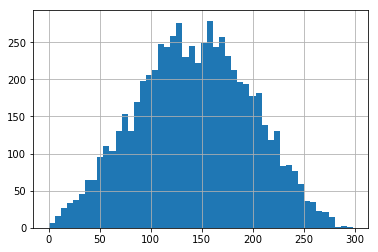

In [14]:
scores['user_assessment_score'].hist(bins=50)

In [15]:
scores['user_handle'].nunique(), scores['assessment_tag'].nunique()

(3114, 54)

In [16]:
scores['user_assessment_date'].min(), scores['user_assessment_date'].max()

('2016-07-13 15:30:44', '2017-11-28 19:34:32')

In [17]:
#Find decay factor using user_assessment_date

scores['user_assessment_date'] = pd.to_datetime(scores['user_assessment_date'])
scores['user_assessment_age'] = pd.to_datetime(scores['user_assessment_date'].max() + pd.DateOffset(1)) - scores['user_assessment_date']

#converting Date to days
scores['user_assessment_age'] = scores['user_assessment_age'].apply(lambda x: x.days)

#Decay factor
scores['user_assessment_decay'] = 1/(scores['user_assessment_age']//30 + 1)

In [18]:
scores.head()

,user_handle,assessment_tag,user_assessment_date,user_assessment_score,user_assessment_age,user_assessment_decay
0,7487,angular-js,2017-08-11 19:03:38,134,110,0.25
1,7487,css,2017-08-11 20:09:56,38,109,0.25
2,7487,html5,2017-07-31 18:59:37,84,121,0.20
3,7487,java,2017-07-31 18:49:27,149,121,0.20
4,7487,javascript,2017-07-31 19:05:03,92,121,0.20


In [19]:
scores['user_assessment_decay'] = scores['user_assessment_score'] * scores['user_assessment_decay']

In [20]:
scores_decay_scaler = MinMaxScaler()
scores['user_assessment_decay'] = scores_decay_scaler.fit_transform(scores['user_assessment_decay'].values.reshape(-1,1))

In [21]:
scores.head()

,user_handle,assessment_tag,user_assessment_date,user_assessment_score,user_assessment_age,user_assessment_decay
0,7487,angular-js,2017-08-11 19:03:38,134,110,0.124074
1,7487,css,2017-08-11 20:09:56,38,109,0.035185
2,7487,html5,2017-07-31 18:59:37,84,121,0.062222
3,7487,java,2017-07-31 18:49:27,149,121,0.110370
4,7487,javascript,2017-07-31 19:05:03,92,121,0.068148


In [22]:
#saving to disk for later use
joblib.dump(scores_decay_scaler, '../models/scores_decay_scaler')

['../models/scores_decay_scaler']

In [23]:
scores.drop(['user_assessment_date', 'user_assessment_score', 'user_assessment_age'], axis=1, inplace=True)

In [24]:
scores.head()

,user_handle,assessment_tag,user_assessment_decay
0,7487,angular-js,0.124074
1,7487,css,0.035185
2,7487,html5,0.062222
3,7487,java,0.110370
4,7487,javascript,0.068148


In [25]:
scores_tags = scores.groupby(by='user_handle')['assessment_tag'].apply(list).reset_index()
scores_decay = scores.groupby(by='user_handle')['user_assessment_decay'].apply(list).reset_index()

In [89]:
scores_final = pd.merge(scores_tags, scores_decay, on='user_handle')

In [90]:
scores_final.head()

,user_handle,assessment_tag,user_assessment_decay
0,2,[photoshop],[0.0343209876543]
1,4,[java],[0.208641975309]
2,9,[azure-infrastructure-as-a-service],[0.522222222222]
3,10,[jquery],[0.681481481481]
4,11,[c-plus-plus],[0.337037037037]


In [91]:
def expand_scores(row):
    tags = row['assessment_tag']
    decays = row['user_assessment_decay']
    for tag, decay in zip(tags,decays):
        row[tag] = decay
    return row

In [92]:
scores_final = scores_final.apply(expand_scores, axis=1)

In [93]:
scores_final.shape

(3114, 57)

In [94]:
scores_final.fillna(value=0, inplace=True)

In [95]:
scores_final.drop(['assessment_tag', 'user_assessment_decay'], axis=1, inplace=True)

In [96]:
scores_final.head()

,3ds-max-environment-modeling,active-directory-administration,after-effects-cc,android,android-associate-developer,angular,angular-js,aspnet-mvc-5,autocad,azure-administrator,...,security-for-hackers-and-developers,sharepoint,solidworks-core-skills,the-scrum-framework,unity-game-development-core-skills,user_handle,using-microsoft-office-2016,video-production,windows-server-management,zbrush-core-skills
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11,0.0,0.0,0.0,0.0


### Views

In [34]:
views.head()

,user_handle,view_date,course_id,author_handle,level,view_time_seconds
0,1,2017-06-27,cpt-sp2010-web-designers-branding-intro,875,Beginner,3786
1,1,2017-06-28,cpt-sp2010-web-designers-branding-intro,875,Beginner,1098
2,1,2017-06-28,cpt-sp2010-web-designers-css,875,Intermediate,4406
3,1,2017-07-27,cpt-sp2010-web-designers-css,875,Intermediate,553
4,1,2017-09-12,aws-certified-solutions-architect-professional,281,Advanced,102


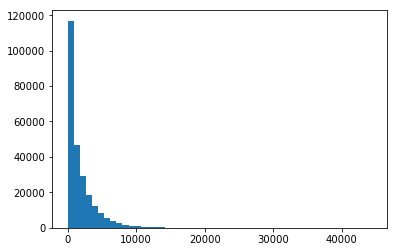

In [35]:
plt.hist((views['view_time_seconds']), bins=50)
plt.show()

In [36]:
#Clipping to remove outliers
max_val = views['view_time_seconds'].quantile(0.995)
views['view_time_seconds'] = np.clip(views['view_time_seconds'], 0 , max_val)

In [37]:
views.head()

,user_handle,view_date,course_id,author_handle,level,view_time_seconds
0,1,2017-06-27,cpt-sp2010-web-designers-branding-intro,875,Beginner,3786.0
1,1,2017-06-28,cpt-sp2010-web-designers-branding-intro,875,Beginner,1098.0
2,1,2017-06-28,cpt-sp2010-web-designers-css,875,Intermediate,4406.0
3,1,2017-07-27,cpt-sp2010-web-designers-css,875,Intermediate,553.0
4,1,2017-09-12,aws-certified-solutions-architect-professional,281,Advanced,102.0


In [38]:
#Finding view strength using a decay factor based on view date

views['view_date'] = pd.to_datetime(views['view_date'])
views['view_age'] = pd.to_datetime(views['view_date'].max() + pd.DateOffset(1)) - views['view_date']
views['view_age'] = views['view_age'].apply(lambda x: x.days)
views['view_decay'] = 1/(views['view_age']//30 + 1)

views['view_stregth'] = views['view_time_seconds'] * views['view_decay']

In [45]:
views.head(2)

,user_handle,view_date,course_id,author_handle,level,view_time_seconds,view_age,view_decay,view_stregth
0,1,2017-06-27,cpt-sp2010-web-designers-branding-intro,875,Beginner,3786.0,155,0.166667,9.308339
1,1,2017-06-28,cpt-sp2010-web-designers-branding-intro,875,Beginner,1098.0,154,0.166667,7.539159


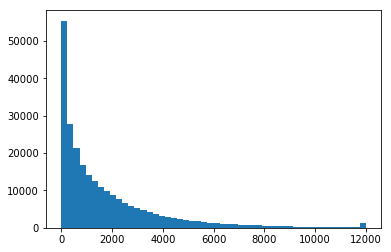

In [46]:
plt.hist((views['view_time_seconds']), bins=50)
plt.show()

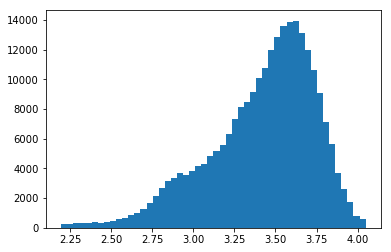

In [47]:
plt.hist((np.log2(views['view_stregth']+3)), bins=50)
plt.show()

In [48]:
#Log Transformation for normal distribution from skewed distribution
views['view_stregth'] = np.log2(views['view_stregth']+3)

In [49]:
views.head(2)

,user_handle,view_date,course_id,author_handle,level,view_time_seconds,view_age,view_decay,view_stregth
0,1,2017-06-27,cpt-sp2010-web-designers-branding-intro,875,Beginner,3786.0,155,0.166667,3.621564
1,1,2017-06-28,cpt-sp2010-web-designers-branding-intro,875,Beginner,1098.0,154,0.166667,3.397688


In [50]:
views_strength_scaler = MinMaxScaler()
views['view_stregth'] = views_strength_scaler.fit_transform(views['view_stregth'].values.reshape(-1,1))

In [51]:
#saving to disk for later use
joblib.dump(views_strength_scaler, '../models/views_strength_scaler')

['../models/views_strength_scaler']

In [52]:
views.head(2)

,user_handle,view_date,course_id,author_handle,level,view_time_seconds,view_age,view_decay,view_stregth
0,1,2017-06-27,cpt-sp2010-web-designers-branding-intro,875,Beginner,3786.0,155,0.166667,0.769309
1,1,2017-06-28,cpt-sp2010-web-designers-branding-intro,875,Beginner,1098.0,154,0.166667,0.648416


In [53]:
views.drop(['view_date', 'view_time_seconds', 'view_age', 'view_decay' ], axis=1, inplace=True)

In [54]:
views = views.groupby(by=['user_handle', 'course_id']).max()['view_stregth'].reset_index()

In [55]:
views.head()

,user_handle,course_id,view_stregth
0,1,aws-certified-solutions-architect-professional,0.453801
1,1,aws-certified-sysops-admin-associate,0.427664
2,1,aws-system-admin-fundamentals,0.799812
3,1,cpt-sp2010-web-designers-branding-intro,0.769309
4,1,cpt-sp2010-web-designers-css,0.782976


In [56]:
views.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105353 entries, 0 to 105352
Data columns (total 3 columns):
user_handle     105353 non-null int64
course_id       105353 non-null object
view_stregth    105353 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.4+ MB


### Tags

In [57]:
tags.head()

,course_id,course_tags
0,12-principles-animation-toon-boom-harmony-1475,2d-animation
1,2d-racing-game-series-unity-5-1312,game-design
2,2d-racing-games-unity-volume-2-1286,game-art
3,2d-racing-games-unity-volume-2-1286,digital-painting
4,2d-racing-games-unity-volume-2-1286,image-editing


In [58]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11337 entries, 0 to 11336
Data columns (total 2 columns):
course_id      11337 non-null object
course_tags    11225 non-null object
dtypes: object(2)
memory usage: 177.2+ KB


In [61]:
#Removing missing data
tags.dropna(inplace=True)

In [62]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11225 entries, 0 to 11336
Data columns (total 2 columns):
course_id      11225 non-null object
course_tags    11225 non-null object
dtypes: object(2)
memory usage: 263.1+ KB


In [63]:
#Grouping tags for each course id
tags = tags.groupby(by='course_id')['course_tags'].apply(set).reset_index()

In [64]:
tags.head()

,course_id,course_tags
0,12-principles-animation-toon-boom-harmony-1475,{2d-animation}
1,2d-racing-game-series-unity-5-1312,{game-design}
2,2d-racing-games-unity-volume-2-1286,"{game-art, image-editing, art-and-design, digi..."
3,2d-racing-games-unity-volume-4-1311,"{game-programming, game-design}"
4,3d-coat-character-concept-sculpting-techniques...,"{3d-sculpting, character-modeling, character-s..."


In [65]:
views.course_id.nunique()

5942

### Views-Tags Merge 

In [66]:
views = pd.merge(views, tags, on='course_id')

In [67]:
views.head()

,user_handle,course_id,view_stregth,course_tags
0,1,aws-certified-solutions-architect-professional,0.453801,"{cloud-computing, cloud-services}"
1,13,aws-certified-solutions-architect-professional,0.792471,"{cloud-computing, cloud-services}"
2,142,aws-certified-solutions-architect-professional,0.810496,"{cloud-computing, cloud-services}"
3,349,aws-certified-solutions-architect-professional,0.723625,"{cloud-computing, cloud-services}"
4,412,aws-certified-solutions-architect-professional,0.667060,"{cloud-computing, cloud-services}"


In [68]:
views[views['user_handle'] == 1]

,user_handle,course_id,view_stregth,course_tags
0,1,aws-certified-solutions-architect-professional,0.453801,"{cloud-computing, cloud-services}"
68,1,aws-certified-sysops-admin-associate,0.427664,"{cloud-computing, iaas}"
141,1,aws-system-admin-fundamentals,0.799812,"{cloud-computing, cloud-services}"
348,1,cpt-sp2010-web-designers-branding-intro,0.769309,{sharepoint}
356,1,cpt-sp2010-web-designers-css,0.782976,{sharepoint}
357,1,react-js-getting-started,0.859181,"{react.js, javascript-libraries}"


In [69]:
views = views.sort_values(by=['user_handle', 'view_stregth'])

In [70]:
views_course = views.groupby(by='user_handle')['course_id'].apply(list).reset_index()
views_strength = views.groupby(by='user_handle')['view_stregth'].apply(list).reset_index()

In [71]:
views_tags= views.groupby(by='user_handle')['course_tags'].apply(list).reset_index()

In [72]:
views_df = pd.merge(views_course, views_strength, on='user_handle')
views_df = pd.merge(views_df, views_tags, on='user_handle')

In [73]:
views_df.head()

,user_handle,course_id,view_stregth,course_tags
0,1,"[aws-certified-sysops-admin-associate, aws-cer...","[0.427663910487, 0.453800660312, 0.76930905169...","[{cloud-computing, iaas}, {cloud-computing, cl..."
1,2,"[introduction-unity-5-2046, after-effects-cc-2...","[0.27364928176, 0.299800405106, 0.303909038965...","[{game-programming}, {marketing}, {compositing..."
2,3,"[java-fundamentals-language, building-realtime...","[0.672522284808, 0.686424567907]","[{java}, {angular, real-time-communication}]"
3,4,"[python-understanding-machine-learning, aws-ce...","[0.363381765434, 0.447724898421, 0.52424806362...","[{data-science, machine-learning}, {cloud-comp..."
4,5,[transitioning-from-live-action-footage-cell-s...,"[0.321358887092, 0.446942752694, 0.53897067245...","[{motion-graphics}, {2d-animation, character-a..."


In [74]:
import collections

def expand_views_record(row):
    course_ids = row['course_id']
    view_stregths = row['view_stregth']
    tags = row['course_tags']
    
    tag_strengths = collections.defaultdict(list)
    for course, strength, ctags in zip(course_ids, view_stregths, tags):
        row[course] = strength
        for tag in ctags:
            tag_strengths[tag].append(strength)

    for tag, values in tag_strengths.items():
        row[tag] = np.max(values)

    return row

In [75]:
views_final = views_df.apply(expand_views_record, axis=1)

In [76]:
views_final.fillna(value=0, inplace=True)

In [77]:
views_final.drop(['course_id','view_stregth','course_tags'], axis=1, inplace=True)

In [88]:
views_final.shape

(8742, 6786)

### Interests

In [79]:
interests.head()

,user_handle,interest_tag,date_followed
0,1,mvc-scaffolding,2017-06-27 16:26:52
1,1,mvc2,2017-06-27 16:26:52
2,1,mvc-html-helpers,2017-06-27 16:26:52
3,1,mvc4-ioc,2017-06-27 16:26:52
4,1,mvc-testing,2017-06-27 16:26:52


In [80]:
interests['date_followed']= pd.to_datetime(interests['date_followed'])
interests['interest_age'] = pd.to_datetime(interests['date_followed'].max() + pd.DateOffset(1)) - interests['date_followed']
interests['interest_age'] = interests['interest_age'].apply(lambda x: x.days)
interests['interest_decay'] = (1/interests['interest_age']//30 + 1)

In [81]:
interests.drop(['date_followed','interest_age'], axis=1, inplace=True)

In [82]:
interests_tag = interests.groupby(by='user_handle')['interest_tag'].apply(list).reset_index()
interests_decay = interests.groupby(by='user_handle')['interest_decay'].apply(list).reset_index()
interests = pd.merge(interests_tag, interests_decay, on='user_handle')

In [83]:
interests.head()

,user_handle,interest_tag,interest_decay
0,1,"[mvc-scaffolding, mvc2, mvc-html-helpers, mvc4...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,2,"[zbrush, maya, 3ds-max, adobe]","[1.0, 1.0, 1.0, 1.0]"
2,3,"[angular, design-patterns, java, react.js, pyt...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,4,"[python, data-analysis, machine-learning, data...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
4,5,"[adobe, maya, zbrush, 3d-animation, 3d-modelin...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [84]:
def expand_interests(row):
    tags = row['interest_tag']
    decays = row['interest_decay']
    
    for tag, decay in zip(tags, decays):
        row[tag] = decay
        
    return row

In [85]:
interests_final = interests.apply(expand_interests, axis=1)

In [86]:
interests_final.fillna(value=0, axis=1, inplace=True)

In [109]:
interests_final.drop(['interest_tag', 'interest_decay'], axis=1, inplace=True)

In [87]:
interests_final.shape

(10000, 751)

### User feature vector and similarity

In [111]:
users = pd.merge(scores_final, views_final, how='outer', on='user_handle')
users = pd.merge(users, interests_final, how='outer', on='user_handle')

In [112]:
users.shape

(10000, 7588)

In [113]:
users.fillna(value=0, inplace=True)
users.set_index('user_handle', inplace=True)

In [114]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 2 to 9971
Columns: 7587 entries, 3ds-max-environment-modeling to zbrush
dtypes: float64(7587)
memory usage: 578.9 MB


In [115]:
sim_matrix = pd.DataFrame(cosine_similarity(users), index=users.index, columns=users.index)

In [116]:
sim_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 2 to 9971
Columns: 10000 entries, 2 to 9971
dtypes: float64(10000)
memory usage: 763.3 MB


#### Testing

In [117]:
sim_matrix.loc[30].sort_values(ascending=False)[:10]

user_handle
30      1.000000
7158    0.741210
8393    0.730284
330     0.712603
4114    0.706199
2720    0.705545
6100    0.663503
3063    0.663161
1662    0.661143
3007    0.657103
Name: 30, dtype: float64

In [120]:
user_id = 30
scores[scores['user_handle'] == user_id]['assessment_tag'].unique(),\
views[views['user_handle'] == user_id]['course_id'].unique(),\
interests[interests['user_handle'] == user_id]['interest_tag'].unique()

(array([], dtype=object),
 array(['r-data-science'], dtype=object),
 array(['big-data', 'data-science', 'data-visualization', 'performance',
        'performance-optimization', 'machine-learning',
        'database-administration'], dtype=object))

In [121]:
user_id = 7158
scores[scores['user_handle'] == user_id]['assessment_tag'].unique(),\
views[views['user_handle'] == user_id]['course_id'].unique(),\
interests[interests['user_handle'] == user_id]['interest_tag'].unique()

(array([], dtype=object),
 array(['r-data-science'], dtype=object),
 array(['data-science', 'machine-learning', 'data-visualization',
        'data-analysis', 'big-data', 'r-framework', 'business-intelligence'], dtype=object))

In [122]:
user_id = 8393
scores[scores['user_handle'] == user_id]['assessment_tag'].unique(),\
views[views['user_handle'] == user_id]['course_id'].unique(),\
interests[interests['user_handle'] == user_id]['interest_tag'].unique()

(array([], dtype=object),
 array(['r-data-science'], dtype=object),
 array(['data-analysis', 'python', 'data-science', 'data-visualization',
        'sql', 'machine-learning', 'big-data', 'business-intelligence'], dtype=object))

In [123]:
user_id = 330
scores[scores['user_handle'] == user_id]['assessment_tag'].unique(),\
views[views['user_handle'] == user_id]['course_id'].unique(),\
interests[interests['user_handle'] == user_id]['interest_tag'].unique()

(array([], dtype=object),
 array(['r-data-science'], dtype=object),
 array(['machine-learning', 'sql', 'big-data', 'sql-server',
        'data-visualization'], dtype=object))

### SVD for dimentionality reduction

In [125]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=500, n_iter=10, random_state=42)
svd.fit(users)
users_svd = svd.transform(users)
users_svd = pd.DataFrame(users_svd, index=users.index)
sim_matrix_svd = pd.DataFrame(cosine_similarity(users_svd), index=users_svd.index, columns=users_svd.index)

In [127]:
sim_matrix_svd.loc[30].sort_values(ascending=False)[:10]

user_handle
30      1.000000
7158    0.740122
5265    0.731207
8393    0.728227
330     0.710626
4114    0.706811
2720    0.704573
1662    0.689206
1734    0.683065
9894    0.674101
Name: 30, dtype: float64

In [128]:
user_id = 5265
scores[scores['user_handle'] == user_id]['assessment_tag'].unique(),\
views[views['user_handle'] == user_id]['course_id'].unique(),\
interests[interests['user_handle'] == user_id]['interest_tag'].unique()

(array([], dtype=object),
 array(['agile-real-world', 'android-start-developing',
        'aws-developer-big-picture', 'big-scrum', 'kanban-fundamentals',
        'microsoft-azure-big-picture', 'r-data-science',
        'ibm-bluemix-applications', 'data-analysis-fundamentals-tableau',
        'enterprise-business-intelligence-tableau-server',
        'tableau-10-whats-new', 'r-data-visualization-beginner'], dtype=object),
 array(['machine-learning', 'data-science', 'business-intelligence',
        'performance', 'performance-optimization', 'r-framework',
        'data-analysis'], dtype=object))

In [130]:
user_id = 1734
scores[scores['user_handle'] == user_id]['assessment_tag'].unique(),\
views[views['user_handle'] == user_id]['course_id'].unique(),\
interests[interests['user_handle'] == user_id]['interest_tag'].unique()

(array([], dtype=object), array(['adv-sql-queries-oracle-sql-server',
        'optimizing-sql-queries-oracle', 'mongodb-big-data-reporting',
        'big-data-hue-cloudera-cdh', 'big-data-hadoop-cluster-cloudera-cdh',
        'bigdata-bigpicture', 'r-data-science', 'sap-getting-started'], dtype=object), array(['big-data', 'business-intelligence', 'data-science',
        'data-visualization'], dtype=object))

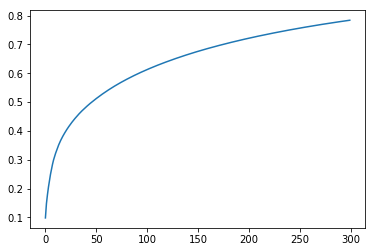

In [168]:
plt.plot(np.cumsum(svd.explained_variance_ratio_))

In [154]:
# Around 300 features are enough to retain 80% data

In [155]:
svd = TruncatedSVD(n_components=300, n_iter=10, random_state=42)
svd.fit(users)
users_svd = svd.transform(users)
users_svd = pd.DataFrame(users_svd, index=users.index)
sim_matrix_svd = pd.DataFrame(cosine_similarity(users_svd), index=users_svd.index, columns=users_svd.index)

In [156]:
sim_matrix_svd.loc[30].sort_values(ascending=False)[:10]

user_handle
30      1.000000
5265    0.741825
7158    0.740696
1734    0.728072
8393    0.726434
330     0.709245
4114    0.709237
2720    0.705054
1662    0.702990
6850    0.696446
Name: 30, dtype: float64

In [159]:
user_id = 6850
scores[scores['user_handle'] == user_id]['assessment_tag'].unique(),\
views[views['user_handle'] == user_id]['course_id'].unique(),\
interests[interests['user_handle'] == user_id]['interest_tag'].unique()

(array([], dtype=object),
 array(['ssas-basic', 'office-365-70-347-clients-end-user-devices',
        'planning-sharepoint-server-2016-topology-services',
        'supporting-office-365-identities',
        'writing-workplace-email-memos-reports-social',
        'setting-up-office-365-identities', 'python-getting-started',
        'data-mining-algorithms-ssas-excel-r',
        'enterprise-business-intelligence-tableau-server', 'r-data-science',
        'ssis-design-patterns-data-warehousing',
        'r-programming-fundamentals', 'tableau-10-whats-new',
        'r-data-visualization-beginner',
        'data-visualization-using-tableau-public',
        'being-better-communicator-grammar-dejargoning-articulation',
        'visual-communication-technical-diagrams'], dtype=object),
 array(['python', 'data-analysis', 'information-security',
        'machine-learning', 'database-administration', 'big-data',
        'business-intelligence', 'data-science', 'communication',
        'performanc

In [162]:
users_svd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 2 to 9971
Columns: 300 entries, 0 to 299
dtypes: float64(300)
memory usage: 23.3 MB


In [178]:
#Writing to database
db_file = '../db/usersim.sqlite'
engine = sqlite3.connect(db_file, timeout=10)

users_svd.to_sql('users', engine, if_exists='replace', index=True)
engine.close()

### API

In [183]:
import heapq

In [579]:
db_file = '../db/usersim.sqlite'

def get_similar_users(user_handle, num_users=10):
    
    minheap = []
    
    try:
        conn = sqlite3.connect(db_file)
        cur = conn.cursor()
        cur.execute('select * from users where user_handle=?', (str(user_handle),))  
        input_user = cur.fetchone()
        
        if not input_user:
            raise Exception('User Not Found')
    
        input_user = np.array(input_user).reshape(1,-1)[:,1:]
        
        cur.execute('select * from users')
        
        users = cur.fetchmany(num_users+1)
        if not users:
                return
        users = np.array(users)
        user_ids = users[:,0]
        users = users[:,1:]
        
        similarities = cosine_similarity(input_user, users)[0]
        
        for user_id, sim in zip(user_ids, similarities):
            if user_id != user_handle:
                minheap.append((sim, int(user_id)))
        
        heapq.heapify(minheap)
                
        while True:
            users = cur.fetchmany(1000)
            if not users:
                break
                
            users = np.array(users)
            
            user_ids = users[:,0]
            users = users[:,1:]
            similarities = cosine_similarity(input_user, users)[0]

            for user_id, sim in zip(user_ids, similarities):
                if user_id != user_handle:
                    heapq.heappushpop(minheap, (sim, int(user_id)))
        
    except Exception as e:
        return
    finally:
        cur.close()
        conn.close()
    
    return [s[1] for s in heapq.nlargest(num_users, minheap)]

In [580]:
get_similar_users(300, 5)

[6738, 2825, 1486, 9647, 3984]

In [576]:
user_id = 300
scores[scores['user_handle'] == user_id]['assessment_tag'].unique(),\
views[views['user_handle'] == user_id]['course_id'].unique(),\
interests[interests['user_handle'] == user_id]['interest_tag'].unique()

(array([], dtype=object),
 array(['dotnet-core-windows-developers-getting-started'], dtype=object),
 array(['c#', '.net', 'asp.net-core', 'python'], dtype=object))

In [577]:
user_id = 6738
scores[scores['user_handle'] == user_id]['assessment_tag'].unique(),\
views[views['user_handle'] == user_id]['course_id'].unique(),\
interests[interests['user_handle'] == user_id]['interest_tag'].unique()

(array(['python'], dtype=object),
 array(['c-sharp-fundamentals-with-visual-studio-2015',
        'csharp-equality-comparisons'], dtype=object),
 array(['c#', 'python', 'asp.net-core', '.net'], dtype=object))

In [ ]:
from flask import Flask, request
from flask import jsonify
import numpy as np
import sqlite3
from sklearn.metrics.pairwise import cosine_similarity
import heapq

app = Flask(__name__)
db_file = '../db/usersim.sqlite'

@app.route('/simusers')
def get_similar_users():
    
    user_handle = request.args.get('userhandle')
    if not user_handle:
        return 'user not found'
    num_users = request.args.get('numusers')
    if not num_users:
        num_users=10
    else:
        num_users = int(num_users)
    
    minheap = []
    conn = None
    cur = None
    try:
        conn = sqlite3.connect(db_file)
        cur = conn.cursor()
        cur.execute('select * from users where user_handle=?', (str(user_handle),))  
        input_user = cur.fetchone()
        
        if not input_user:
            raise Exception('User Not Found')
    
        input_user = np.array(input_user).reshape(1,-1)[:,1:]
        
        cur.execute('select * from users')
        
        users = cur.fetchmany(num_users+1)
        if not users:
            return
        users = np.array(users)
        user_ids = users[:,0]
        users = users[:,1:]
        
        similarities = cosine_similarity(input_user, users)[0]
        
        for user_id, sim in zip(user_ids, similarities):
            if user_id != user_handle:
                minheap.append((sim, int(user_id)))
        
        heapq.heapify(minheap)
                
        while True:
            users = cur.fetchmany(1000)
            if not users:
                break
                
            users = np.array(users)
            
            user_ids = users[:,0]
            users = users[:,1:]
            similarities = cosine_similarity(input_user, users)[0]

            for user_id, sim in zip(user_ids, similarities):
                if user_id != user_handle:
                    heapq.heappushpop(minheap, (sim, int(user_id)))
        
    except Exception as e:
        return str(e)
    finally:
        if cur is not None:
            cur.close()
        if conn is not None:
            conn.close()
    
    return jsonify([s[1] for s in heapq.nlargest(num_users, minheap)])

if __name__ == "__main__":
        app.run(host="0.0.0.0", port=9080)